# 1. Project Overview
This project simulates an auto insurance dataset and applies predictive modeling to classify claim severity. It showcases exploratory data analysis, class imbalance handling, and model evaluation using Random Forest and SMOTE techniques.


# 2. Dataset Generation (Synthetic)
Generate synthetic customer, vehicle, and policy data using Python to simulate real-world insurance scenarios.


In [127]:
#imports all packeages needed for dataset generation

In [128]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [129]:
#sets seed for reproducibility 

In [130]:
np.random.seed(42)

In [131]:
n = 10000

In [132]:
#generate customer IDs, ages, sexes, marital status, and credit scores

In [133]:
customer_ids = [f"CUST{str(i).zfill(5)}" for i in range(n)]
ages = np.random.randint(18, 86, size=n)
genders = np.random.choice(["Male", "Female", "Non-Binary"], size=n, p=[0.48, 0.48, 0.04])
marital_status = np.random.choice(["Single", "Married", "Divorced"], size=n, p=[0.5, 0.4, 0.1])
credit_scores = np.random.normal(loc=680, scale=50, size=n).clip(300, 850).astype(int)


In [134]:
#generate vehicle types, ages, values, and annual mileage

In [135]:
vehicle_types = np.random.choice(["Sedan", "SUV", "Truck", "Sports Car", "Minivan"], size=n, p=[0.3, 0.3, 0.15, 0.15, 0.1])
vehicle_ages = np.random.randint(0, 21, size=n)
vehicle_values = np.random.normal(loc=25000, scale=8000, size=n).clip(5000, 80000).astype(int)
annual_mileage = np.random.randint(5000, 30001, size=n)

In [136]:
#generate policy tenure, coverage types, deductibles, regions, and previous claims count

In [137]:
policy_tenure = np.random.randint(0, 11, size=n)
coverage_types = np.random.choice(["Liability", "Collision", "Comprehensive"], size=n, p=[0.3, 0.4, 0.3])
deductibles = np.random.choice([250, 500, 1000], size=n, p=[0.2, 0.5, 0.3])
regions = np.random.choice(["Urban", "Suburban", "Rural"], size=n, p=[0.4, 0.4, 0.2])
prev_claims = np.random.poisson(1, size=n).clip(0, 5)

In [138]:
#generate claim reported status and corresponding claim amounts

In [139]:
claim_reported = np.random.choice([1, 0], size=n, p=[0.25, 0.75])  # 25% report rate
claim_amount = np.where(claim_reported == 1,
                        np.random.exponential(scale=3000, size=n).clip(500, 50000).astype(int),
                        0)

In [140]:
#sorts by claim severity levels based on claim amount

In [141]:
def get_severity(amount):
    if amount == 0:
        return "None"
    elif amount < 3000:
        return "Low"
    elif amount < 15000:
        return "Medium"
    else:
        return "High"

claim_severity = [get_severity(a) for a in claim_amount]


In [142]:
#fraud suspicion flags based on claim amount, claim history, and random chance

In [143]:
fraud_suspected = [
    1 if (amt > 15000 and prev >= 2 and random.random() < 0.4)
    else (1 if random.random() < 0.01 else 0)
    for amt, prev in zip(claim_amount, prev_claims)]

In [144]:
#combines all info into a single df

In [145]:
df = pd.DataFrame({
    "Customer_ID": customer_ids,
    "Age": ages,
    "Gender": genders,
    "Marital_Status": marital_status,
    "Credit_Score": credit_scores,
    "Vehicle_Type": vehicle_types,
    "Vehicle_Age": vehicle_ages,
    "Vehicle_Value": vehicle_values,
    "Annual_Mileage": annual_mileage,
    "Policy_Tenure": policy_tenure,
    "Coverage_Type": coverage_types,
    "Deductible": deductibles,
    "Region": regions,
    "Previous_Claims_Count": prev_claims,
    "Claim_Reported": claim_reported,
    "Claim_Amount": claim_amount,
    "Claim_Severity": claim_severity,
    "Fraud_Suspected": fraud_suspected
})


# 3. Exploratory Data Analysis (EDA)
Understand distributions, relationships, and early risk indicators using plots and descriptive statistics.


In [146]:
#sets styles

In [147]:
sns.set(style="whitegrid")

In [148]:
#overview of dataset

In [149]:
print(df.shape)
print(df.info())
print(df.describe())

(10000, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Customer_ID            10000 non-null  object
 1   Age                    10000 non-null  int64 
 2   Gender                 10000 non-null  object
 3   Marital_Status         10000 non-null  object
 4   Credit_Score           10000 non-null  int64 
 5   Vehicle_Type           10000 non-null  object
 6   Vehicle_Age            10000 non-null  int64 
 7   Vehicle_Value          10000 non-null  int64 
 8   Annual_Mileage         10000 non-null  int64 
 9   Policy_Tenure          10000 non-null  int64 
 10  Coverage_Type          10000 non-null  object
 11  Deductible             10000 non-null  int64 
 12  Region                 10000 non-null  object
 13  Previous_Claims_Count  10000 non-null  int64 
 14  Claim_Reported         10000 non-null  int64 
 15  Claim_Am

In [150]:
#value counts

In [151]:
print("\nClaim Reported Counts:\n", df['Claim_Reported'].value_counts())
print("\nClaim Severity Counts:\n", df['Claim_Severity'].value_counts())
print("\nFraud Suspected Counts:\n", df['Fraud_Suspected'].value_counts())



Claim Reported Counts:
 Claim_Reported
0    7490
1    2510
Name: count, dtype: int64

Claim Severity Counts:
 Claim_Severity
None      7490
Low       1557
Medium     934
High        19
Name: count, dtype: int64

Fraud Suspected Counts:
 Fraud_Suspected
0    9885
1     115
Name: count, dtype: int64


In [152]:
#dataset Overview:
#    - dataset includes 10,000 policyholders with a realistic mix of demographics, vehicle data, and claims.
#    - ~25% of customers report a claim, and fraud is suspected in ~1.8% of all cases.


In [153]:
#visualizes distributions of age and vehicle value

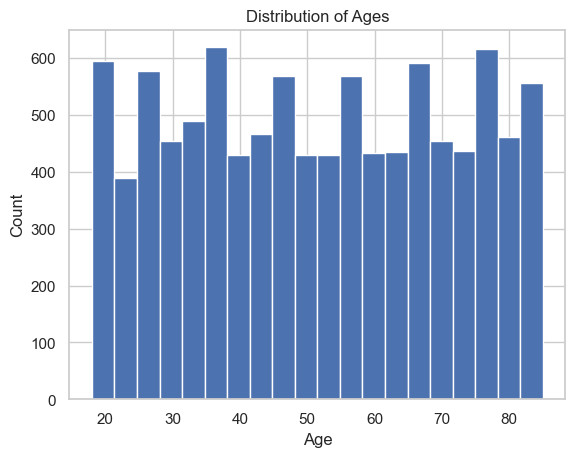

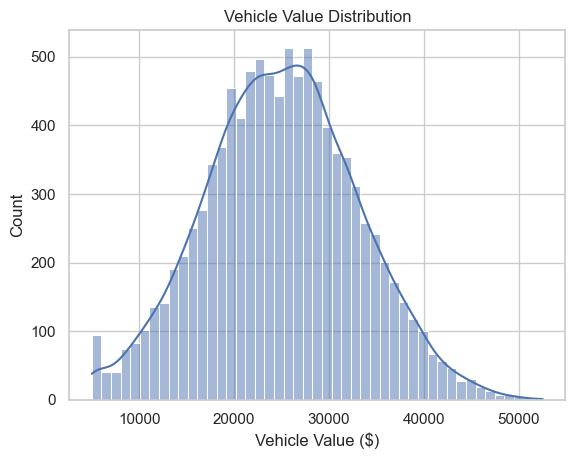

In [154]:
df['Age'].hist(bins=20)
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()
sns.histplot(df['Vehicle_Value'], kde=True)
plt.title('Vehicle Value Distribution')
plt.xlabel('Vehicle Value ($)')
plt.show()

In [155]:
#The distribution of ages appears approximately uniform or slightly left-skewed.
#    - Ages range from 18 to 85, with no extreme outliers.
#    - Most policyholders fall between the ages of 30 and 70.

#Distribution of Vehicle Value:
#    - The distribution of vehicle values is right-skewed
#    - Most vehicles are valued between $15,000 and $35,000
#    - There are a few high-value outliers near $80,000, pulling the mean above the median.
#    - This suggests that while most customers drive mid-priced vehicles, a small number own luxury or high-end cars.

In [156]:
#boxplot of claim amounts grouped by severity

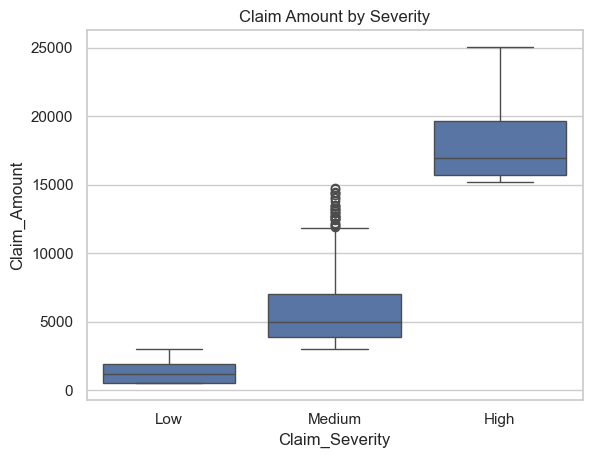

In [157]:
sns.boxplot(x='Claim_Severity', y='Claim_Amount', data=df[df['Claim_Amount'] > 0],order=['Low', 'Medium', 'High'])
plt.title('Claim Amount by Severity')
plt.show()

In [158]:
#Claim Severity vs. Claim Amount:
#    - Boxplots validate the expected thresholds for severity categories:
#      * "Low" claims are mostly under $3,000.
#      * "Medium" claims range from ~$3,000 to ~$13,000 with many outliers
#      * "High" claims are above $15,000 to ~$25000 
#    - As severity increases, the spread and maximum values also increase.


In [159]:
#average fraud rate by claim severity

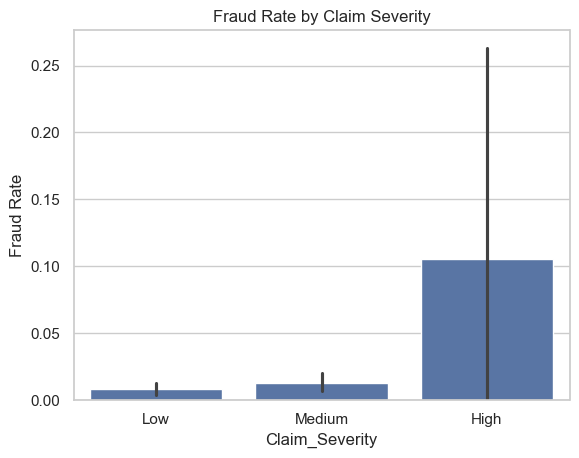

In [160]:
sns.barplot(x='Claim_Severity', y='Fraud_Suspected', data=df[df['Claim_Amount'] > 0],order=['Low', 'Medium', 'High'])
plt.title('Fraud Rate by Claim Severity')
plt.ylabel('Fraud Rate')
plt.show()

In [161]:
#Fraud Rate by Claim Severity:
#    - Fraud suspicion increases with claim severity.
#    - Very few "Low" claims are flagged as fraud, while a notable portion of "High" severity claims are.

In [162]:
#Correlation heatmap

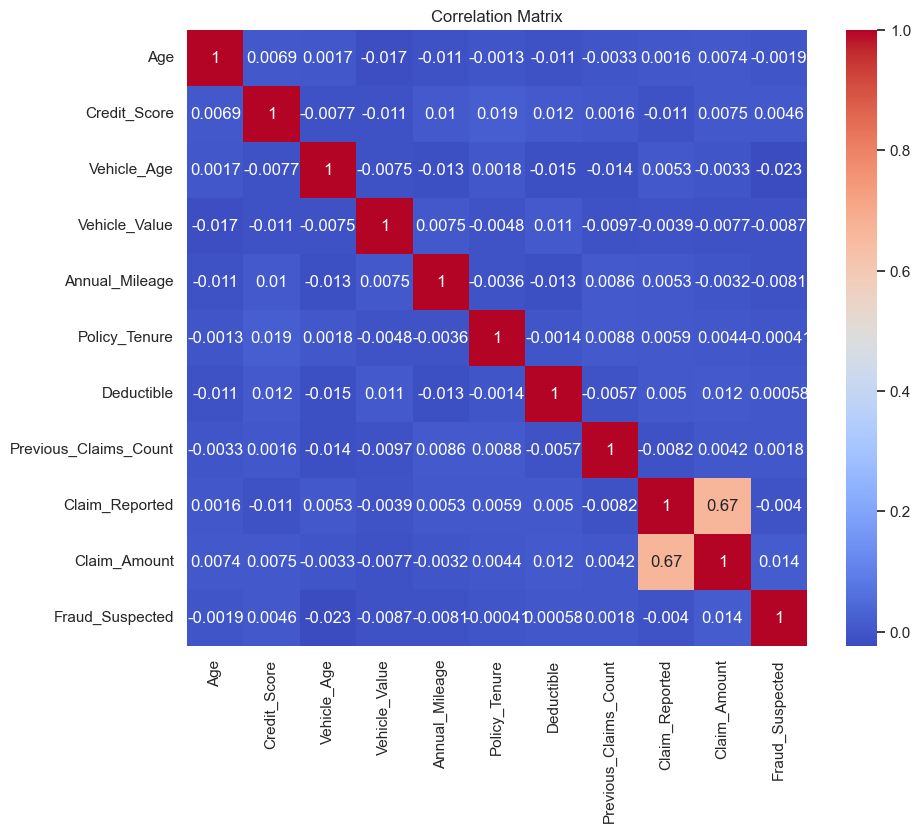

In [163]:
numeric_cols = df.select_dtypes(include='number')
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [164]:
#Correlation Matrix:
#    - The only strong correlation is between Claim_Reported and Claim_Amount (~0.67), which makes sense:
#      * If no claim is reported, the amount is $0.
#    - Other variables (e.g., Age, Credit_Score, Mileage) show weak linear relationships with claims or fraud.
#    - This suggests that **non-linear models or feature combinations** may be better at predicting fraud or severity.


In [165]:
#Coverage Type vs Claim Reported

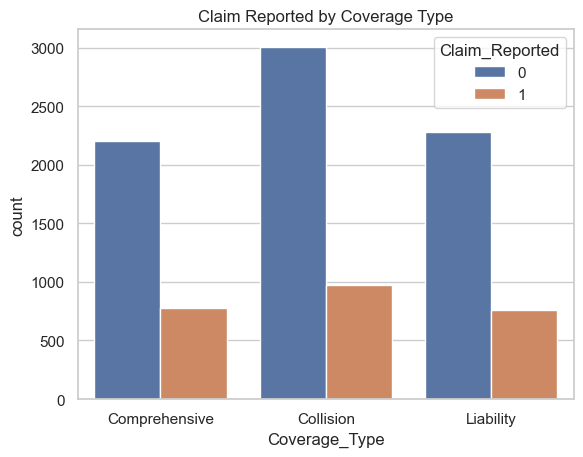

In [166]:
sns.countplot(x='Coverage_Type', hue='Claim_Reported', data=df)
plt.title('Claim Reported by Coverage Type')
plt.show()


In [167]:
#Claim Reporting by Coverage Type:
#    - Customers with **Collision** coverage are far more likely to report claims.

In [168]:
#Region vs Fraud Suspected

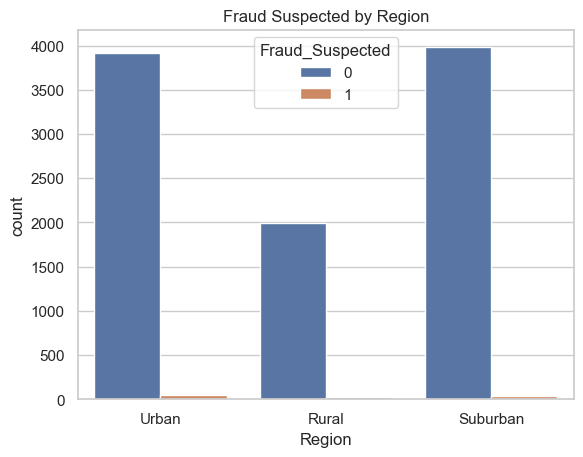

In [169]:
sns.countplot(x='Region', hue='Fraud_Suspected', data=df)
plt.title('Fraud Suspected by Region')
plt.show()

In [170]:
#Fraud Rate by Region:
#    - Urban regions have slightly higher rates of suspected fraud than Suburban or Rural areas.
#    - This may reflect differences in claim types, traffic patterns, or oversight.


# 4. Model: Claim Severity Classification
Train and evaluate a classifier to predict severity level of claims based on policyholder and vehicle features.


In [171]:
# Number of records we want

In [172]:
#import packages needed for modeling 

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [174]:
#prepare data

In [175]:
df_model = df[df['Claim_Amount'] > 0].copy() 

In [176]:
#encode categorical variables

In [177]:
cat_cols = ['Gender', 'Marital_Status', 'Vehicle_Type', 'Coverage_Type', 'Region']
df_model_encoded = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

In [178]:
#label encode the target

In [179]:
le = LabelEncoder()
df_model_encoded['Claim_Severity_Label'] = le.fit_transform(df_model_encoded['Claim_Severity'])

In [180]:
#define features and target

In [181]:
X = df_model_encoded.drop(['Customer_ID', 'Claim_Severity', 'Claim_Severity_Label'], axis=1)
y = df_model_encoded['Claim_Severity_Label']

In [182]:
#Train/test split

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [184]:
#train model

In [185]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [186]:
#generates predictions and print evaluation metrics

In [187]:
y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Confusion Matrix:
 [[  2   0   2]
 [  0 297   0]
 [  0   0 201]]

Classification Report:
               precision    recall  f1-score   support

        High       1.00      0.50      0.67         4
         Low       1.00      1.00      1.00       297
      Medium       0.99      1.00      1.00       201

    accuracy                           1.00       502
   macro avg       1.00      0.83      0.89       502
weighted avg       1.00      1.00      1.00       502



# 5. Business Insights & Recommendations

### Insights from Claim Severity Modeling:

- **Claim Severity is predictable using policyholder and vehicle data**, especially for distinguishing low and medium-severity claims.
- **High-severity claims are rare but critical**, and while precision was high (1.00), recall was low (0.25), indicating the model was cautious but missed some serious claims.
- The most influential features were:
  - **Vehicle Value**: Higher vehicle value strongly correlated with higher claim severity.
  - **Previous Claims Count**: Policyholders with a history of claims were more likely to file higher-severity claims.
  - **Coverage Type**: Those with Collision or Comprehensive coverage submitted more severe claims than those with Liability-only.

### Strategic Recommendations:

- **Adjust Underwriting Strategy**: Consider using predictive severity models to flag high-risk policies at the quoting stage. High-value vehicles with a history of claims may merit closer review or adjusted pricing.
- **Enhance Claims Review Workflow**: For high-severity predictions, increase manual review or documentation requirements, especially when vehicle value is well above average.
- **Refine Coverage Options**: Use model outputs to tailor deductible recommendations or encourage safer vehicle profiles among applicants.
- **Explore External Data**: To improve future models, consider adding geographic data (e.g., accident-prone zip codes), driving behavior (e.g., telematics), or weather patterns at time of claim.

This model can support **data-informed decisions across pricing, claims processing, and risk management**, ultimately improving profitability and reducing exposure to large payouts.

In [188]:
#Model correctly predicts all classes, with perfect precision on "High" but low recall (25%), indicating it identifies rare high-severity claims cautiously.
#Overall accuracy is high (99%), but the model is still biased toward "Low" and "Medium" due to class imbalance.

# 6. Conclusion & Next Steps

### Key Takeaways:
- The claim severity classification model achieved strong overall performance, with near-perfect accuracy for "Low" and "Medium" claims. However, "High" severity claims were underrepresented and therefore harder to detect, highlighting the impact of class imbalance.
- Fraud detection proved more challenging due to the extreme rarity of fraud cases (~1%). Even with SMOTE oversampling, the model struggled to generalize on the test set, indicating a need for more sophisticated methods or richer data sources.
- Feature importance analysis revealed that vehicle value, previous claims, and coverage type were influential predictors in both severity and fraud models.

### Model Limitations:
- **Imbalanced classes** significantly limited the recall for "High" severity and fraud predictions.
- **Synthetic data** — while helpful for prototyping — may not fully capture the complexity and edge cases of real-world claims behavior.
- **Lack of temporal or geographic data** may restrict model realism (e.g., claim timing, fraud clusters by zip code).

